In [53]:
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from itertools import combinations

In [54]:
# Pull the CSV and check out the layout.

raw_cars_df = pd.read_csv("../data/cars-dataset.csv")

raw_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
382,34.0,4,108.0,70.00,2245.0,16.9,82,3,toyota corolla
300,23.9,8,260.0,90.00,3420.0,22.2,79,1,oldsmobile cutlass salon brougham
309,41.5,4,98.0,76.00,2144.0,14.7,80,2,vw rabbit
221,17.5,8,305.0,145.0,3880.0,12.5,77,1,chevrolet caprice classic
379,36.0,4,98.0,70.00,2125.0,17.3,82,1,mercury lynx l
156,16.0,8,400.0,170.0,4668.0,11.5,75,1,pontiac catalina
60,20.0,4,140.0,90.00,2408.0,19.5,72,1,chevrolet vega
326,43.4,4,90.0,48.00,2335.0,23.7,80,2,vw dasher (diesel)
312,37.2,4,86.0,65.00,2019.0,16.4,80,3,datsun 310
346,32.3,4,97.0,67.00,2065.0,17.8,81,3,subaru


In [55]:
"""
The data is mostly good, but some of the horsepowers are missing. The dataset is small enough
that I don't want to just drop the whole row, but leaving the value set for "?" will cause problems.
So we're going to impute the missing values by replacing the "?" with mean/median horsepower values.

To reduce margin of error I'll use the mean values from the same origin and number of cylinders.
"""

# Replace "?" with NaN so we can use fillna() later
raw_cars_df['horsepower'] = raw_cars_df['horsepower'].replace('?', pd.NA)

# Convert horsepower to numeric, forcing errors to NaN
raw_cars_df['horsepower'] = pd.to_numeric(
    raw_cars_df['horsepower'], errors='coerce')

# This function will replace all the missing horsepower values with 
# mean values based on cylinder and origin.
# So like a 6 cylinder vehicle from Europe will get a mean of other 
# 6 cylinder horsepowers from europe.
def impute_missing_hp(row, grouped_means):
    if pd.isna(row['horsepower']):
        return grouped_means.loc[(row['cylinders'], row['origin'])]
    return row['horsepower']

# Calculate the mean horsepower for each cylinders-origin group
grouped_means = raw_cars_df.groupby(['cylinders', 'origin'])[
    'horsepower'].mean()

# Use the imput_missing_hp function on every row
raw_cars_df['horsepower'] = raw_cars_df.apply(
    lambda row: impute_missing_hp(row, grouped_means), axis=1)

all_cars_df = raw_cars_df

all_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
265,17.5,8,318.0,140.0,4080.0,13.7,78,1,dodge magnum xe
326,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel)
258,20.6,6,231.0,105.0,3380.0,15.8,78,1,buick century special
245,36.1,4,98.0,66.0,1800.0,14.4,78,1,ford fiesta
198,33.0,4,91.0,53.0,1795.0,17.4,76,3,honda civic
372,27.0,4,151.0,90.0,2735.0,18.0,82,1,pontiac phoenix
277,16.2,6,163.0,133.0,3410.0,15.8,78,2,peugeot 604sl
35,17.0,6,250.0,100.0,3329.0,15.5,71,1,chevrolet chevelle malibu
186,27.0,4,101.0,83.0,2202.0,15.3,76,2,renault 12tl
105,13.0,8,360.0,170.0,4654.0,13.0,73,1,plymouth custom suburb


In [56]:
# Here's a separate dataframe for each origin.

american_cars_df = all_cars_df[all_cars_df['origin']== 1]

european_cars_df = all_cars_df[all_cars_df['origin'] == 2]

japanese_cars_df = all_cars_df[all_cars_df['origin'] == 3]

american_cars_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,151.0,90.0,2950.0,17.3,82,1,chevrolet camaro
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [57]:
grouped_means

cylinders  origin
3          3          99.250000
4          1          80.956522
           2          78.311475
           3          75.579710
5          2          82.333333
6          1          99.671233
           2         113.500000
           3         115.833333
8          1         158.300971
Name: horsepower, dtype: float64

Text(0.5, 1.0, 'European')

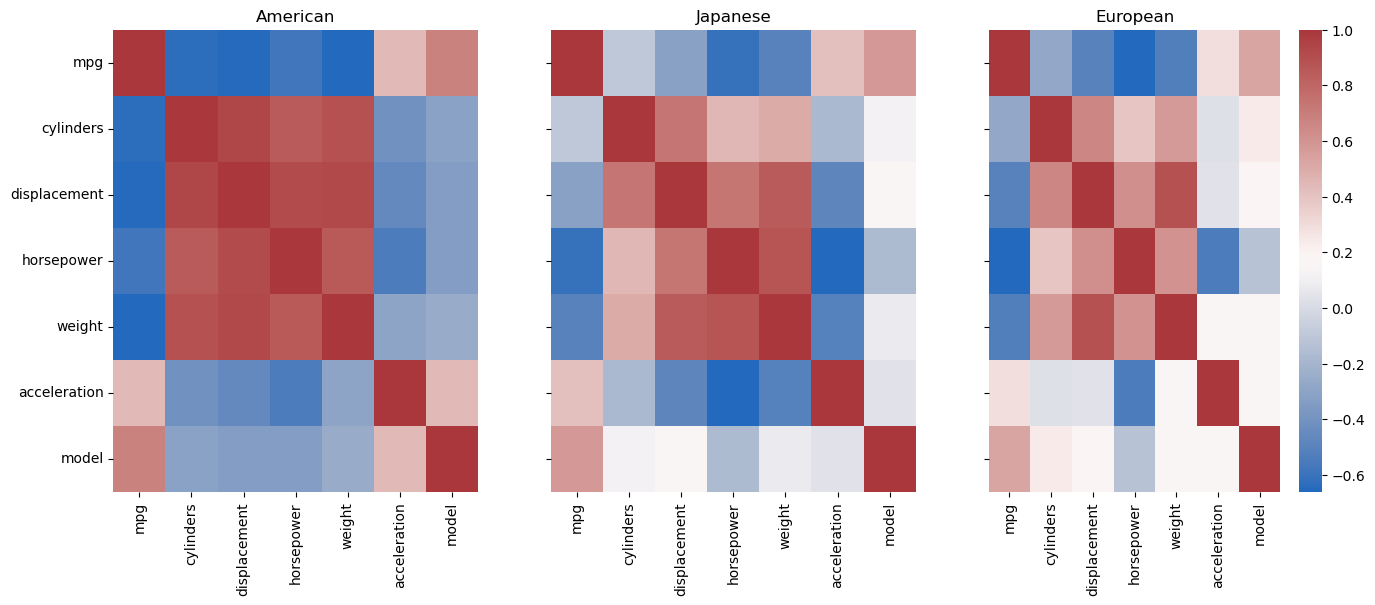

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (16,6))
p1 = sns.heatmap(american_cars_df[['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']].corr(numeric_only=True), cmap = 'vlag', cbar = False, ax=ax1)
p1.set_title('American')
p2 = sns.heatmap(japanese_cars_df[['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']].corr(numeric_only=True), cmap = 'vlag',cbar = False, ax=ax2)
p2.set_title('Japanese')
p3 = sns.heatmap(european_cars_df[['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']].corr(numeric_only=True), cmap = 'vlag',ax=ax3)
p3.set_title('European')

Text(0.5, 0.04, 'Horsepower')

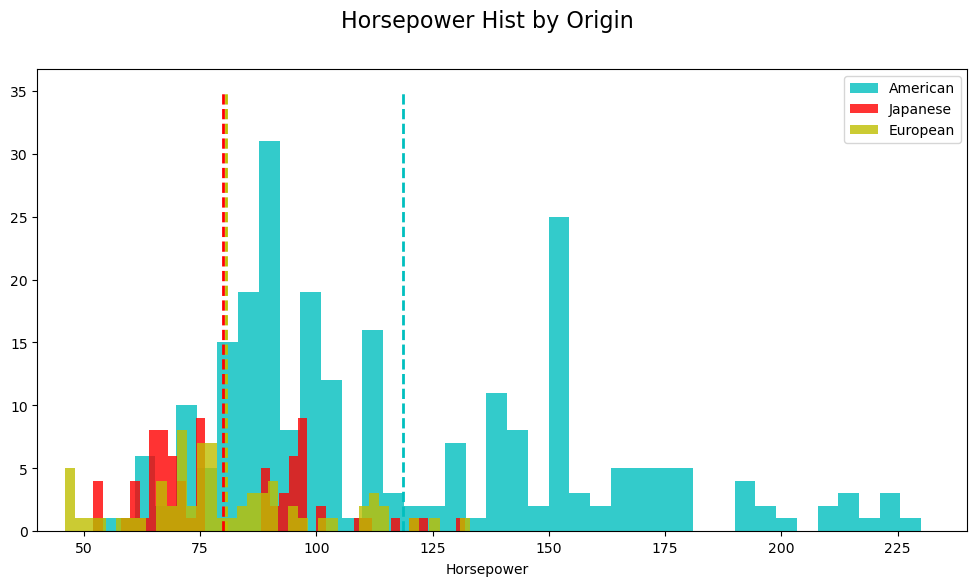

In [59]:
fig, axs = plt.subplots(figsize=(12,6), sharex=True,sharey=True)

axs.hist(american_cars_df['horsepower'], bins =40, label = 'American', alpha = 0.8, color='c')
#axs[0].set_title('American')
axs.vlines(x=american_cars_df['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='c', 
          linestyles='dashed',
          linewidth=2)
axs.hist(japanese_cars_df['horsepower'], bins =40, label = 'Japanese', alpha = 0.8, color='r')
#axs[1].set_title('Japanese')
axs.vlines(x=japanese_cars_df['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='r', 
          linestyles='dashed',
          linewidth=2)
axs.hist(european_cars_df['horsepower'], bins =40, label = 'European', alpha = 0.8, color='y')
#axs[2].set_title('European')
axs.vlines(x=european_cars_df['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='y', 
          linestyles='dashed',
          linewidth=2)
fig.suptitle('Horsepower Hist by Origin', fontsize=16)
axs.set_xlim(40,240)
leg = axs.legend(loc='upper right')
fig.text(0.5, 0.04, 'Horsepower', ha='center')

In [60]:
## American vs Japanese

t, p = stats.ttest_ind(american_cars_df['horsepower'], japanese_cars_df['horsepower'], equal_var=False, alternative = 'greater')
print(t, p)

12.002106182601999 1.5609617485892588e-27


In [61]:
## American vs European
t, p = stats.ttest_ind(american_cars_df['horsepower'], european_cars_df['horsepower'], equal_var=False, alternative = 'greater')
print(t, p)

10.972981640208372 4.039044082092876e-23


In [62]:
## Japanese vs European
t, p = stats.ttest_ind(japanese_cars_df['horsepower'], european_cars_df['horsepower'], equal_var=False)
print(t, p)

-0.21210750365660963 0.8323324198191369


In [63]:
pre_1975_american = american_cars_df[american_cars_df['model'] < 75]
pre_1975_japanese = japanese_cars_df[japanese_cars_df['model'] < 75]
pre_1975_european = european_cars_df[european_cars_df['model'] < 75]

In [64]:
## American vs Japanese pre 1975

t, p = stats.ttest_ind(pre_1975_american['horsepower'], pre_1975_japanese['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(pre_1975_american['horsepower'])/np.std(pre_1975_japanese['horsepower']))
print(f'American vs Japanese pre 75= {t, p}')

## American vs European pre 1975

t, p = stats.ttest_ind(pre_1975_american['horsepower'], pre_1975_european['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(pre_1975_american['horsepower'])/np.std(pre_1975_european['horsepower']))
print(f'American vs European pre 75= {t, p}')

## Japanese vs European pre 1975

t, p = stats.ttest_ind(pre_1975_japanese['horsepower'], pre_1975_european['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(pre_1975_japanese['horsepower'])/np.std(pre_1975_european['horsepower']))
print(f'Japanese vs European pre 75= {t, p}')

2.7356707921071073
American vs Japanese pre 75= (5.456628184675727, 1.2788545057131554e-07)
2.3013044487125853
American vs European pre 75= (6.841750666425084, 1.4165068584661527e-10)
0.8412212665910878
Japanese vs European pre 75= (1.1817923748227674, 0.12168079623354776)


In [65]:
post_1975_american = american_cars_df[american_cars_df['model'] >= 75]
post_1975_japanese = japanese_cars_df[japanese_cars_df['model'] >= 75]
post_1975_european = european_cars_df[european_cars_df['model'] >= 75]

In [66]:
## American vs Japanese post 1975

t, p = stats.ttest_ind(post_1975_american['horsepower'], post_1975_japanese['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(post_1975_american['horsepower'])/np.std(post_1975_japanese['horsepower']))
print(f'American vs Japanese 75+ = {t, p}')

## American vs European post 1975

t, p = stats.ttest_ind(post_1975_american['horsepower'], post_1975_european['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(post_1975_american['horsepower'])/np.std(post_1975_european['horsepower']))
print(f'American vs European 75+ = {t, p}')

## Japanese vs European post 1975

t, p = stats.ttest_ind(post_1975_japanese['horsepower'], post_1975_european['horsepower'], equal_var=True, alternative = 'greater')
print(np.std(post_1975_japanese['horsepower'])/np.std(post_1975_european['horsepower']))
print(f'Japanese vs European 75+ = {t, p}')

1.60493591674099
American vs Japanese 75+ = (6.437597856816043, 4.370408997336456e-10)
1.422508347191978
American vs European 75+ = (4.825096842323321, 1.4531933041038858e-06)
0.8863334245024234
Japanese vs European 75+ = (-0.9039546167860407, 0.8158930611793699)


In [67]:
## pre 1975 mannwhitneyu

## American vs Japanese pre 1975

t, p = stats.mannwhitneyu(pre_1975_american['horsepower'], pre_1975_japanese['horsepower'], alternative = 'greater')
print(f'American vs Japanese pre 75= {t, p}')

## American vs European pre 1975

t, p = stats.mannwhitneyu(pre_1975_american['horsepower'], pre_1975_european['horsepower'],  alternative = 'greater')
print(f'American vs European pre 75= {t, p}')

## Japanese vs European pre 1975

t, p = stats.mannwhitneyu(pre_1975_japanese['horsepower'], pre_1975_european['horsepower'],  alternative = 'greater')
print(f'Japanese vs European pre 75= {t, p}')



American vs Japanese pre 75= (1867.5, 1.472346095782926e-07)
American vs European pre 75= (2483.5, 3.9063193109178327e-10)
Japanese vs European pre 75= (352.5, 0.07701068605177426)


In [68]:
## post 1975 mannwhitneyu

## American vs Japanese post 1975

t, p = stats.mannwhitneyu(post_1975_american['horsepower'], post_1975_japanese['horsepower'], alternative = 'greater')
print(f'American vs Japanese pre 75= {t, p}')

## American vs European post 1975

t, p = stats.mannwhitneyu(post_1975_american['horsepower'], post_1975_european['horsepower'],  alternative = 'greater')
print(f'American vs European pre 75= {t, p}')

## Japanese vs European post 1975

t, p = stats.mannwhitneyu(post_1975_japanese['horsepower'], post_1975_european['horsepower'],  alternative = 'greater')
print(f'Japanese vs European pre 75= {t, p}')


American vs Japanese pre 75= (6573.5, 1.8448425911504772e-10)
American vs European pre 75= (4692.0, 2.5039016568806363e-07)
Japanese vs European pre 75= (1014.0, 0.9458003667453236)


In [69]:
## pre vs post for all origins

## American pre vs American post

t, p = stats.ttest_ind(pre_1975_american['horsepower'], post_1975_american['horsepower'], equal_var=True, alternative = 'greater')

print(f'American pre 75 vs American 75+ = {t, p}')

## European pre vs Eurpoean post

t, p = stats.ttest_ind(pre_1975_european['horsepower'], post_1975_european['horsepower'], equal_var=True, alternative = 'greater')
print(f'European pre 75 vs European 75+ = {t, p}')

## Japanese pre vs Japanese post

t, p = stats.ttest_ind(pre_1975_japanese['horsepower'], post_1975_japanese['horsepower'], equal_var=True, alternative = 'greater')
print(f'Japanese pre 75 vs Japanese 75+ = {t, p}')

American pre 75 vs American 75+ = (7.60571704427236, 2.963712214570493e-13)
European pre 75 vs European 75+ = (-0.3728159471422776, 0.6447774977018252)
Japanese pre 75 vs Japanese 75+ = (1.7590281425622036, 0.041272688511499886)


In [70]:
## pre vs post for all origins

## American pre vs American post

t, p = stats.mannwhitneyu(pre_1975_american['horsepower'], post_1975_american['horsepower'], alternative = 'greater')

print(f'American pre 75 vs American 75+ = {t, p}')

## European pre vs Eurpoean post

t, p = stats.mannwhitneyu(pre_1975_european['horsepower'], post_1975_european['horsepower'], alternative = 'greater')
print(f'European pre 75 vs European 75+ = {t, p}')

## Japanese pre vs Japanese post

t, p = stats.mannwhitneyu(pre_1975_japanese['horsepower'], post_1975_japanese['horsepower'], alternative = 'greater')
print(f'Japanese pre 75 vs Japanese 75+ = {t, p}')

American pre 75 vs American 75+ = (11076.5, 1.3585167942689674e-10)
European pre 75 vs European 75+ = (564.5, 0.5789547623867778)
Japanese pre 75 vs Japanese 75+ = (741.0, 0.07176534727865189)


Text(0.5, 0.04, 'Horsepower')

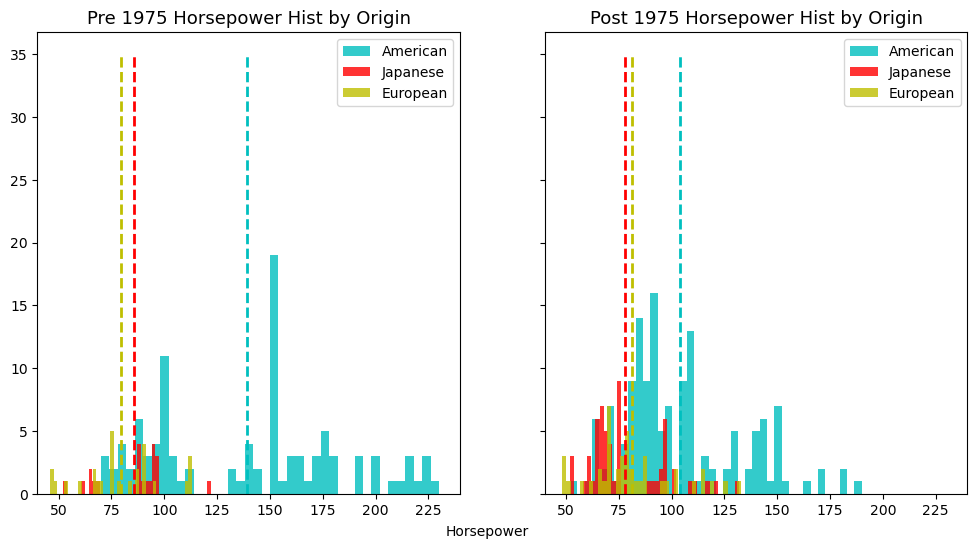

In [79]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,6), sharex=True,sharey=True)

axs[0].hist(pre_1975_american['horsepower'], bins =40, label = 'American', alpha = 0.8, color='c')
#axs[0].set_title('American')
axs[0].vlines(x=pre_1975_american['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='c', 
          linestyles='dashed',
          linewidth=2)
axs[0].hist(pre_1975_japanese['horsepower'], bins =40, label = 'Japanese', alpha = 0.8, color='r')
#axs[1].set_title('Japanese')
axs[0].vlines(x=pre_1975_japanese['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='r', 
          linestyles='dashed',
          linewidth=2)
axs[0].hist(pre_1975_european['horsepower'], bins =40, label = 'European', alpha = 0.8, color='y')
#axs[2].set_title('European')
axs[0].vlines(x=pre_1975_european['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='y', 
          linestyles='dashed',
          linewidth=2)

#right chart


axs[1].hist(post_1975_american['horsepower'], bins =40, label = 'American', alpha = 0.8, color='c')
#axs[0].set_title('American')
axs[1].vlines(x=post_1975_american['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='c', 
          linestyles='dashed',
          linewidth=2)
axs[1].hist(post_1975_japanese['horsepower'], bins =40, label = 'Japanese', alpha = 0.8, color='r')
#axs[1].set_title('Japanese')
axs[1].vlines(x=post_1975_japanese['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='r', 
          linestyles='dashed',
          linewidth=2)
axs[1].hist(post_1975_european['horsepower'], bins =40, label = 'European', alpha = 0.8, color='y')
#axs[2].set_title('European')
axs[1].vlines(x=post_1975_european['horsepower'].mean(), 
          ymin=0, 
          ymax=35, 
          colors='y', 
          linestyles='dashed',
          linewidth=2)
axs[0].set_title('Pre 1975 Horsepower Hist by Origin',size=13)
axs[1].set_title('Post 1975 Horsepower Hist by Origin',size=13)
axs[0].set_xlim(40,240)
axs[1].set_xlim(40,240)
leg = axs[0].legend(loc='upper right')
leg = axs[1].legend(loc='upper right')
fig.text(0.5, 0.04, 'Horsepower', ha='center')